# GPA statistics

## Load `mean_shape`, model and dataset

In [1]:
import torch

from wings.config import PROCESSED_DATA_DIR, MODELS_DIR
from wings.modeling.litnet import LitNet
from wings.modeling.loss import DiceLoss

mean_coords = torch.load(
    PROCESSED_DATA_DIR / "mask_datasets" / 'rectangle' / "mean_shape.pth", weights_only=False
)

checkpoint_path = MODELS_DIR / 'unet-rectangle-epoch=08-val_loss=0.14-unet-training-rectangle_1.ckpt'
unet_model = torch.hub.load(
    'mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=False
)
num_epochs = 60
model = LitNet.load_from_checkpoint(checkpoint_path, model=unet_model, num_epochs=num_epochs, criterion=DiceLoss())
model.eval()

test_dataset = torch.load(
    PROCESSED_DATA_DIR / "mask_datasets" / 'rectangle' / "test_mask_dataset.pth",
    weights_only=False
)
max_n = len(test_dataset)


2025-10-17 00:41:08.608 | INFO     | wings.config:<module>:40 - PROJ_ROOT path is: /home/mkrajew/bees
2025-10-17 00:41:08.696 | INFO     | wings.config:<module>:62 - torch.cuda.get_device_name()='NVIDIA RTX A3000 12GB Laptop GPU'
Using cache found in /home/mkrajew/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


## Preprocess data

In [2]:
from wings.gpa import recover_order
from wings.visualizing.image_preprocess import mask_to_coords, unet_reverse_padding
import torch
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

original_labels = []
predicted_labels = []
bad_masks = 0
bad_indices = []

for idx, (image, label, original_coords, orig_size) in enumerate(tqdm(test_dataset, desc="Evaluating")):
    image = image.to(device).unsqueeze(0)

    with torch.no_grad():
        output = model(image)
        mask = torch.round(output).squeeze().cpu().numpy()

    try:
        mask_coords = mask_to_coords(mask, max_iter=1)
        mask_height, mask_width = mask.shape
        orig_width, orig_height = orig_size

        pad_left, pad_top, pad_right, pad_bottom = unet_reverse_padding(mask, orig_width, orig_height)
        mask_coords = [(x - pad_left, y - pad_bottom) for x, y in mask_coords]

        scale_x = orig_width / (mask_width - pad_right - pad_left)
        scale_y = orig_height / (mask_height - pad_top - pad_bottom)
        mask_coords_scaled = torch.tensor([(x * scale_x, y * scale_y) for x, y in mask_coords])

        reordered = recover_order(mean_coords, mask_coords_scaled)
        orig = original_coords.view(-1, 2)

        original_labels.append(orig.cpu().numpy())
        predicted_labels.append(reordered.cpu().numpy())

    except Exception as e:
        bad_masks += 1
        bad_indices.append(idx)
        continue

print(f"Total samples: {len(test_dataset)}")
print(f"Failed masks: {bad_masks}")

original_labels = np.stack(original_labels)
predicted_labels = np.stack(predicted_labels)

print(f"original_labels.shape = {original_labels.shape}")
print(f"predicted_labels.shape = {predicted_labels.shape}")


Evaluating: 100%|██████████| 2172/2172 [00:26<00:00, 81.33it/s]

Total samples: 2172
Failed masks: 37
original_labels.shape = (2135, 19, 2)
predicted_labels.shape = (2135, 19, 2)


# Calculate Statistics

## Images with the worst points assignments

In [7]:
import numpy as np

n = 10

original = original_labels
predicted = predicted_labels
errors = np.linalg.norm(predicted - original, axis=2)  # shape: (n_samples, 19)
flat_errors = errors.flatten()

# Get indices of top-n largest errors
top_n_flat_indices = np.argpartition(-flat_errors, n)[:n]
top_n_flat_indices = top_n_flat_indices[np.argsort(-flat_errors[top_n_flat_indices])]

# Convert back to 2D indices (sample index, inner index)
top_n_indices_2d = np.array(np.unravel_index(top_n_flat_indices, errors.shape)).T  # shape: (n, 2)
top_n_sample_indices = top_n_indices_2d[:, 0]

all_indices = list(range(len(test_dataset)))
good_indices = [i for i in all_indices if i not in bad_indices]

original_dataset_indices = [good_indices[i] for i in top_n_sample_indices]

print("Top-n errors (dataset_index, point, error_value):")
for idx, ((sample_idx, inner_idx), dataset_idx) in enumerate(zip(top_n_indices_2d, original_dataset_indices)):
    print(
        f"{idx + 1:2.0f}:\tIndex={dataset_idx:5.0f}\t\tPoint {inner_idx:2.0f}\tError={errors[sample_idx, inner_idx]:7.2f}"
    )


Top-n errors (dataset_index, point, error_value):
 1:	Index=  522		Point  2	Error= 165.78
 2:	Index= 1815		Point 17	Error= 126.55
 3:	Index=  522		Point  3	Error=  70.10
 4:	Index= 1350		Point 18	Error=  20.94
 5:	Index=  259		Point 17	Error=  16.12
 6:	Index=  284		Point  3	Error=  12.83
 7:	Index= 1732		Point  4	Error=  10.98
 8:	Index= 1409		Point 13	Error=   9.84
 9:	Index=  517		Point 13	Error=   9.63
10:	Index= 1117		Point 13	Error=   9.26


## Threshold

In [8]:
threshold = 3.5

num_errors_above_threshold = np.sum(errors > threshold)
total_points = errors.size
percentage = (num_errors_above_threshold / total_points) * 100

print(f"Number of points with error > {threshold}: {num_errors_above_threshold}")
print(f"Percent of all points: {percentage:.2f}%")


Number of points with error > 3.5: 2194
Percent of all points: 5.41%


### Threshold graph

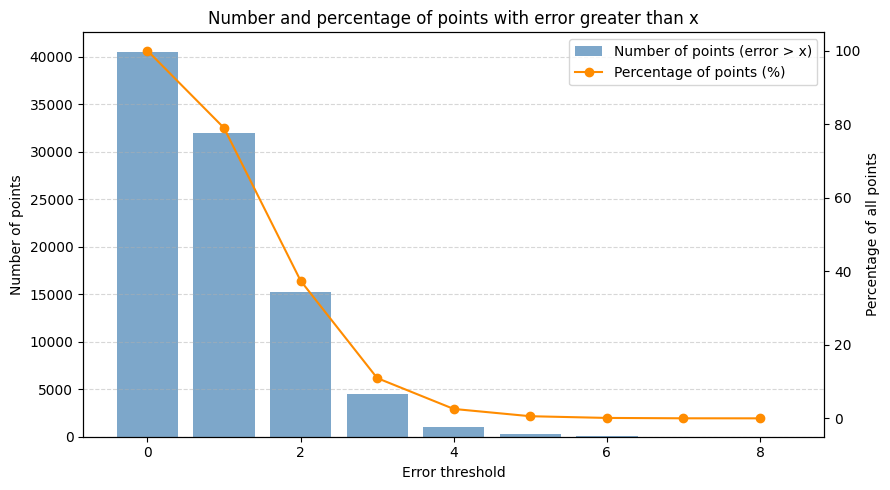

In [17]:
import numpy as np
import matplotlib.pyplot as plt

flat_errors = errors.flatten()
# m = int(np.ceil(flat_errors.max()))
m = 8

x_values = np.arange(0, m + 1)

counts = [np.sum(flat_errors > x) for x in x_values]
percentages = [100 * c / len(flat_errors) for c in counts]

# Graph
fig, ax1 = plt.subplots(figsize=(9, 5))

ax1.bar(x_values, counts, color='steelblue', alpha=0.7, label='Number of points (error > x)')
ax1.set_xlabel('Error threshold')
ax1.set_ylabel('Number of points')
# ax1.set_yscale('log')  # logaritmic scale
ax1.grid(True, which="both", axis='y', linestyle='--', alpha=0.5)
ax1.set_title('Number and percentage of points with error greater than x')

ax2 = ax1.twinx()
ax2.plot(x_values, percentages, color='darkorange', marker='o', label='Percentage of points (%)')
ax2.set_ylabel('Percentage of all points')

# ax1.set_ylim(bottom=0)
# ax2.set_ylim(bottom=0)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

plt.tight_layout()
plt.show()
